# KE5105 - Building Electrical Consumption Forecasting

# Modelling 6 - Preliminary model

## Summary of Findings
* **MRB** building dataset with **academic calendar features**
* Base 4x128 GRU 2x32 Dense
    * Min Validation MAE (normalised) = 2.249 (0.0165) @ epoch 148
* 4x128 GRU 2x32 Dense with dropouts (.2/.2)
    * Min Validation MAE = xxx (xxx) @ epoch xxx

## Load libraries

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython',
 '/home/tkokkeng/Documents/KE5105/ETL/source']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import datetime
import myUtilities as mu
import pickle

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion

from keras.models import Sequential, load_model
from keras import layers
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend

Using TensorFlow backend.


## Load data for building MRB

In [4]:
mrb_train = mu.load_data_by_bldg(['MRB'], 'imputed_train')

In [5]:
mrb_train[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31617 entries, 2015-06-12 07:30:00 to 2017-03-31 23:30:00
Data columns (total 10 columns):
PWMMRIC1                     29851 non-null float64
PWMMRIC2                     29851 non-null float64
BTUMochtarRiady              29448 non-null float64
PWMMRIC1_30min_avg           29818 non-null float64
PWMMRIC2_30min_avg           29818 non-null float64
BTUMochtarRiady_30min_avg    29416 non-null float64
PWM_sumadd                   29818 non-null float64
PWM_30min_avg                29861 non-null float64
BTU_sumadd                   29416 non-null float64
BTU_30min_avg                29469 non-null float64
dtypes: float64(10)
memory usage: 2.7 MB


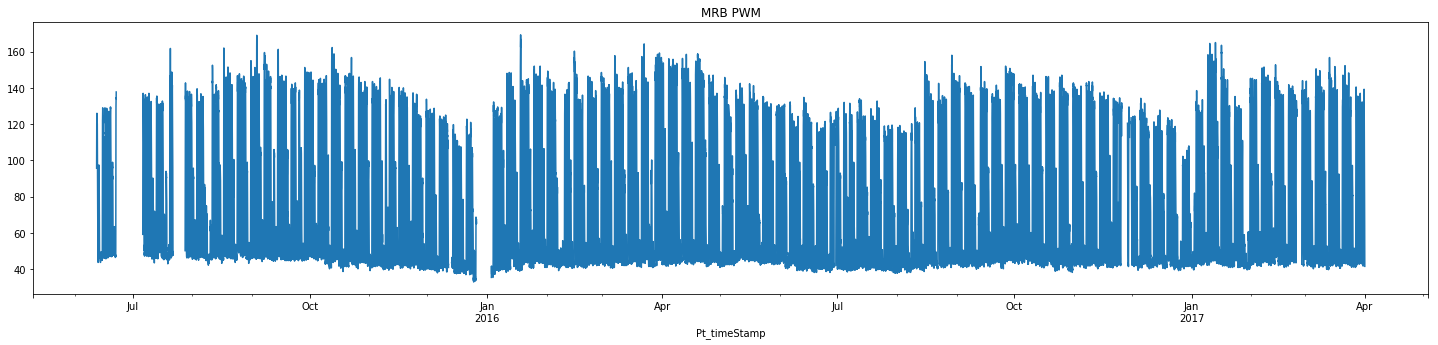

In [6]:
mrb_train_df = mrb_train[0][1]
mrb_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='MRB PWM')

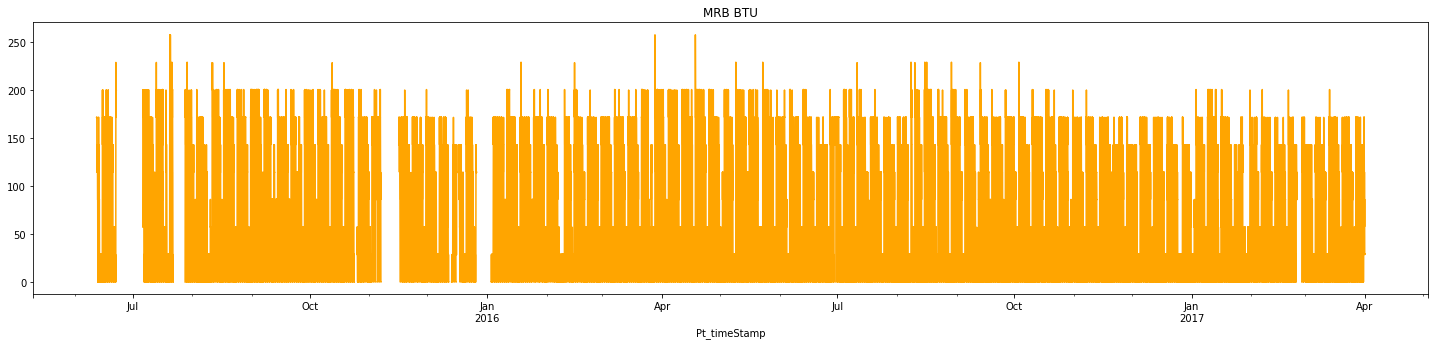

In [7]:
mrb_train_df['BTU_30min_avg'].plot(figsize=(25, 5), title='MRB BTU', color='orange')

## Add academic calendar feature

* [NUS 2015/2016 Academic Calendar](http://www.nus.edu.sg/registrar/info/calendar/AY2015-2016.pdf)
* [NUS 2016/2017 Academic Calendar](http://www.nus.edu.sg/registrar/info/calendar/AY2016-2017.pdf)

In [8]:
mrb_train_df['acad'] = 'instruction'

# Academic calendar 2015/2016
# Semester 1
mrb_train_df.loc[:'2015-08-02 23:30', 'acad'] = 'vacation'
mrb_train_df.loc['2015-08-03 00:00':'2015-08-08 23:30', 'acad'] = 'orientation'
mrb_train_df.loc['2015-09-19 00:00':'2015-09-27 23:30', 'acad'] = 'recess'
mrb_train_df.loc['2015-11-14 00:00':'2015-11-20 23:30', 'acad'] = 'reading'
mrb_train_df.loc['2015-11-21 00:00':'2015-12-05 23:30', 'acad'] = 'exam'
mrb_train_df.loc['2015-12-06 00:00':'2016-01-10 23:30', 'acad'] = 'vacation'

# Semester 2
mrb_train_df.loc['2016-02-20 00:00':'2016-02-28 23:30', 'acad'] = 'recess'
mrb_train_df.loc['2016-04-16 00:00':'2016-04-22 23:30', 'acad'] = 'reading'
mrb_train_df.loc['2016-04-23 00:00':'2016-05-07 23:30', 'acad'] = 'exam'
mrb_train_df.loc['2016-05-08 00:00':'2016-07-31 23:30', 'acad'] = 'vacation'

# Public Holiday
mrb_train_df.loc['2015-07-17 00:00':'2015-07-17 23:30', 'acad'] = 'holiday'  # Hari Raya Puasa
mrb_train_df.loc['2015-08-07 00:00':'2015-08-07 23:30', 'acad'] = 'holiday'  # SG50
mrb_train_df.loc['2015-08-09 00:00':'2015-08-10 23:30', 'acad'] = 'holiday'  # National Day on 9 Aug Sun
mrb_train_df.loc['2015-09-24 00:00':'2015-09-24 23:30', 'acad'] = 'holiday'  # Hari Raya Haji
mrb_train_df.loc['2015-11-10 00:00':'2015-11-10 23:30', 'acad'] = 'holiday'  # Deepavali
mrb_train_df.loc['2015-12-24 14:00':'2015-12-25 23:30', 'acad'] = 'holiday'  # Christmas + half-day
mrb_train_df.loc['2015-12-31 14:00':'2016-01-01 23:30', 'acad'] = 'holiday'  # New Year + half-day
mrb_train_df.loc['2016-02-08 00:00':'2016-02-09 23:30', 'acad'] = 'holiday'  # Chinese New Year on Mon/Tue
mrb_train_df.loc['2016-03-25 00:00':'2016-03-25 23:30', 'acad'] = 'holiday'  # Good Fri
mrb_train_df.loc['2016-05-01 00:00':'2016-05-02 23:30', 'acad'] = 'holiday'  # Labour Day on Sun 1 May
mrb_train_df.loc['2016-05-21 00:00':'2016-05-21 23:30', 'acad'] = 'holiday'  # Vesak Day
mrb_train_df.loc['2016-07-06 00:00':'2016-07-06 23:30', 'acad'] = 'holiday'  # Hari Raya Puasa

# Academic calendar 2016/2017
# Semester 1
mrb_train_df.loc['2016-08-01 00:00':'2016-08-06 23:30', 'acad'] = 'orientation'
mrb_train_df.loc['2016-09-17 00:00':'2016-09-25 23:30', 'acad'] = 'recess'
mrb_train_df.loc['2016-11-12 00:00':'2016-11-18 23:30', 'acad'] = 'reading'
mrb_train_df.loc['2016-11-19 00:00':'2016-12-03 23:30', 'acad'] = 'exam'
mrb_train_df.loc['2016-12-04 00:00':'2017-01-08 23:30', 'acad'] = 'vacation'

# Semester 2
mrb_train_df.loc['2017-02-18 00:00':'2017-02-26 23:30', 'acad'] = 'recess'
# mrb_train_df.loc['2017-04-15 00:00':'2017-04-21 23:30', 'acad'] = 'reading'
# mrb_train_df.loc['2017-04-22 00:00':'2017-05-06 00:00', 'acad'] = 'exam'
# mrb_train_df.loc['2017-05-07 00:00':'2017-08-06 23:30', 'acad'] = 'vacation'

# Public Holiday
mrb_train_df.loc['2016-08-09 00:00':'2016-08-09 23:30', 'acad'] = 'holiday'  # National Day
mrb_train_df.loc['2016-09-12 00:00':'2016-09-12 23:30', 'acad'] = 'holiday'  # Hari Raya Haji
mrb_train_df.loc['2016-10-29 00:00':'2016-10-29 23:30', 'acad'] = 'holiday'  # Deepavali
mrb_train_df.loc['2016-12-26 00:00':'2016-12-26 23:30', 'acad'] = 'holiday'  # Christmas on Sun
mrb_train_df.loc['2017-01-02 00:00':'2017-01-02 23:30', 'acad'] = 'holiday'  # New Year on Sun
mrb_train_df.loc['2017-01-27 14:00':'2017-01-30 23:30', 'acad'] = 'holiday'  # Chinese New Year on 28/29 Jan Sat/Sun + half-day
# mrb_train_df.loc['2017-04-14 00:00':'2017-04-14 23:30', 'acad'] = 'holiday'  # Good Fri
# mrb_train_df.loc['2017-05-01 00:00':'2017-05-01 23:30', 'acad'] = 'holiday'  # Labour Day
# mrb_train_df.loc['2017-05-10 00:00':'2017-05-10 23:30', 'acad'] = 'holiday'  # Vesak Day
# mrb_train_df.loc['2017-06-25 00:00':'2017-06-25 23:30', 'acad'] = 'holiday'  # Hari Raya Puasa

In [9]:
mrb_train_df.loc['2016-08-08 08:00':'2016-08-08 18:00', ['PWM_30min_avg', 'acad']]

PWM_30min_avg         acad
Pt_timeStamp                                   
2016-08-08 08:00:00          91.50  instruction
2016-08-08 08:30:00          99.75  instruction
2016-08-08 09:00:00         107.25  instruction
2016-08-08 09:30:00         111.25  instruction
2016-08-08 10:00:00         110.75  instruction
2016-08-08 10:30:00         111.75  instruction
2016-08-08 11:00:00         113.25  instruction
2016-08-08 11:30:00         115.25  instruction
2016-08-08 12:00:00         114.25  instruction
2016-08-08 12:30:00         113.00  instruction
2016-08-08 13:00:00         112.25  instruction
2016-08-08 13:30:00         111.00  instruction
2016-08-08 14:00:00         113.75  instruction
2016-08-08 14:30:00         117.25  instruction
2016-08-08 15:00:00         120.25  instruction
2016-08-08 15:30:00         118.50  instruction
2016-08-08 16:00:00         117.50  instruction
2016-08-08 16:30:00         117.25  instruction
2016-08-08 17:00:00         112.75  instruction
2016-08-08 17:30:00         111.75  instruction
2016-08-08 18:00:00         107.25  instruction

In [10]:
mrb_train_df.loc['2016-08-09 08:00':'2016-08-09 18:00', ['PWM_30min_avg', 'acad']]

PWM_30min_avg     acad
Pt_timeStamp                               
2016-08-09 08:00:00          47.50  holiday
2016-08-09 08:30:00          49.00  holiday
2016-08-09 09:00:00          60.50  holiday
2016-08-09 09:30:00          59.50  holiday
2016-08-09 10:00:00          57.25  holiday
2016-08-09 10:30:00          54.50  holiday
2016-08-09 11:00:00          55.50  holiday
2016-08-09 11:30:00          55.75  holiday
2016-08-09 12:00:00          55.25  holiday
2016-08-09 12:30:00          55.50  holiday
2016-08-09 13:00:00          55.00  holiday
2016-08-09 13:30:00          56.00  holiday
2016-08-09 14:00:00          55.00  holiday
2016-08-09 14:30:00          55.75  holiday
2016-08-09 15:00:00          55.25  holiday
2016-08-09 15:30:00          55.75  holiday
2016-08-09 16:00:00          56.00  holiday
2016-08-09 16:30:00          55.75  holiday
2016-08-09 17:00:00          54.25  holiday
2016-08-09 17:30:00          53.75  holiday
2016-08-09 18:00:00          52.25  holiday

## Split a validation set out from the train set

In [11]:
mrb_train_split_df = mrb_train_df[:20000]
mrb_val_split_df = mrb_train_df[20000:]

In [12]:
print('train split = %s\nvalidation split = %s' % (mrb_train_split_df.shape, mrb_val_split_df.shape))

train split = (20000, 11)
validation split = (11617, 11)


## Transform the training data

* Normalise the data - convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [13]:
# Create a transformation pipleline to prepare the training dataset for RNN.
float_attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
float_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(float_attrbs)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [14]:
cat_attrbs = ['acad']
cat_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(cat_attrbs)),
    ('one_hot_encoder', OneHotEncoder(sparse=False))
])

In [15]:
my_pipeline = FeatureUnion(transformer_list=[
    ("float_pipeline", float_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [16]:
mrb_train_data = my_pipeline.fit_transform(mrb_train_split_df)
mrb_train_data

array([[0.46055046, 0.66601942, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.55412844, 0.66699029, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.60366972, 0.66601942, 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.16880734, 0.11067961, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.07889908, 0.11067961, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.07155963, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [17]:
mrb_train_data.shape

(20000, 9)

Text(0.5, 1.0, 'Normalised PWM Training Data')

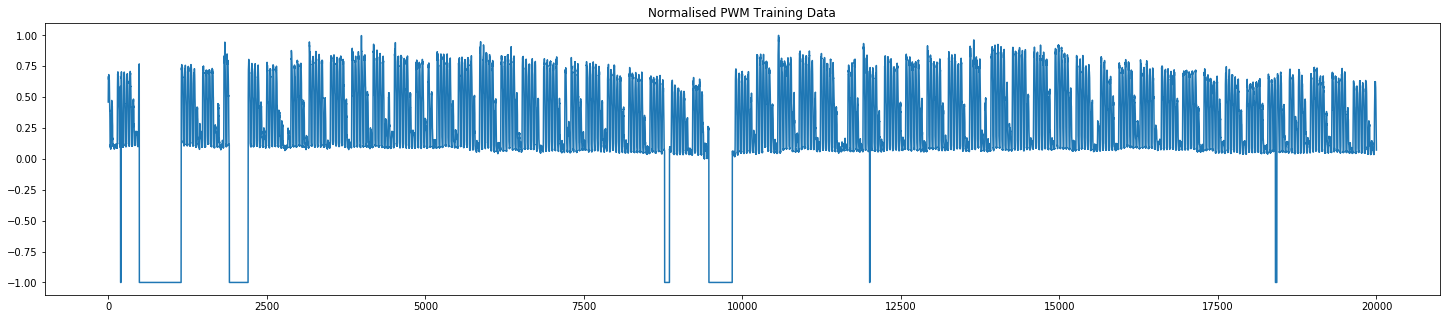

In [18]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 0])
plt.title('Normalised PWM Training Data')

Text(0.5, 1.0, 'Normalised BTU Training Data')

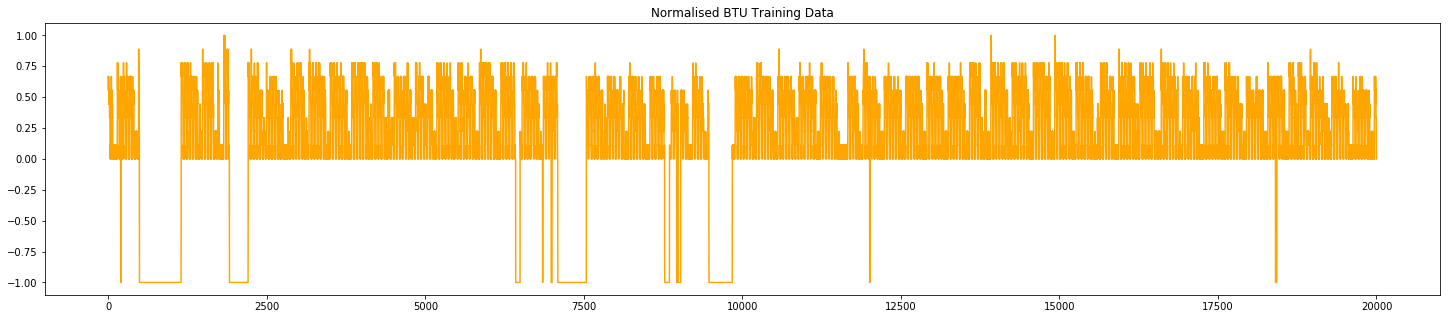

In [19]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

In [20]:
mrb_val_data = my_pipeline.transform(mrb_val_split_df)
mrb_val_data

array([[0.05321101, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.07155963, 0.11067961, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05688073, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.13211009, 0.11067961, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.10825688, 0.11426533, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.06314127, 0.11424788, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [21]:
mrb_val_data.shape

(11617, 9)

Text(0.5, 1.0, 'Normalised PWM Validation Data')

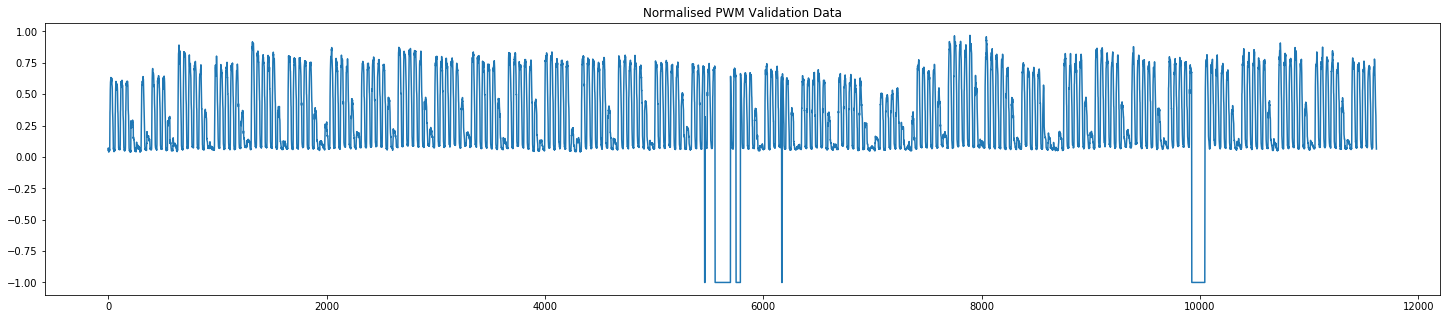

In [22]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_val_data.shape[0]), mrb_val_data[:, 0])
plt.title('Normalised PWM Validation Data')

Text(0.5, 1.0, 'Normalised BTU Validation Data')

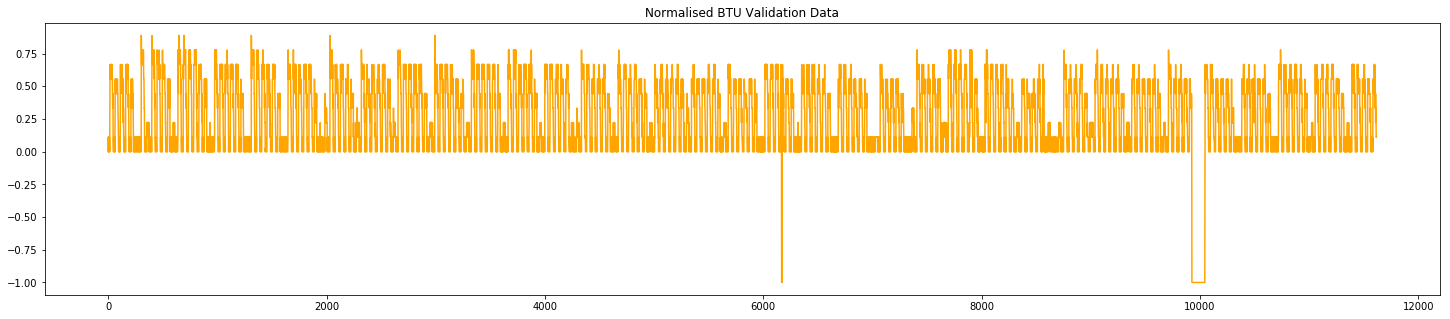

In [23]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_val_data.shape[0]), mrb_val_data[:, 1], color='orange')
plt.title('Normalised BTU Validation Data')

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [24]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

In [25]:
# Custom mape metric. Skips all zero values of y-true in computing the mape metric.
import tensorflow as tf
def mape_skip_zeros(y_true, y_pred):
    y_true1 = tf.boolean_mask(y_true, y_true > 0)
    y_pred1 = tf.boolean_mask(y_pred, y_true > 0)
    diff = backend.abs((y_true1 - y_pred1) / y_true1)
    return 100. * backend.mean(diff, axis=-1)

## 4x128 GRU, 2x32 Dense Layer Model 

In [26]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [27]:
model = Sequential()
model.add(layers.CuDNNGRU(128, return_sequences=True, input_shape=(None, mrb_train_data.shape[-1])))
model.add(layers.CuDNNGRU(128, return_sequences=True))
model.add(layers.CuDNNGRU(128, return_sequences=True))
model.add(layers.CuDNNGRU(128))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(clipnorm=1.), loss='mae', metrics=[mape_skip_zeros])
# model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape', mape_skip_zeros])  # for testing only

In [28]:
gen_train = mu.DataGenerator(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(mrb_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 87


#### Check if there are zero values in the training and validation mini-batches

In [24]:
np.any(mrb_train_data[[ j for i in gen_train.dict_batch_idx.values() for j in i ], 0] == 0)

True

In [25]:
# There are two zero values.
np.nonzero(mrb_train_data[[ j for i in gen_train.dict_batch_idx.values() for j in i ], 0] == 0)

(array([8123, 8125]),)

In [26]:
np.any(mrb_val_data[[ j for i in gen_val.dict_batch_idx.values() for j in i ], 0] == 0)

False

#### Testing the custom mape metric

The results below show that in training, Keras mape has large values while the custom mape does not. In validation, both have the same values.

Training start time = 2019-03-05 17:48:22.672464
Epoch 1/5
 - 13s - loss: 0.1060 - mean_absolute_percentage_error: 23185.2863 - mape_skip_zeros: 42.6790 - val_loss: 0.0551 - val_mean_absolute_percentage_error: 33.8443 - val_mape_skip_zeros: 33.8443
Epoch 2/5
 - 12s - loss: 0.0614 - mean_absolute_percentage_error: 6996.8420 - mape_skip_zeros: 25.9611 - val_loss: 0.0317 - val_mean_absolute_percentage_error: 15.7137 - val_mape_skip_zeros: 15.7137
Epoch 3/5
 - 12s - loss: 0.0516 - mean_absolute_percentage_error: 7892.1599 - mape_skip_zeros: 21.8444 - val_loss: 0.0421 - val_mean_absolute_percentage_error: 16.0838 - val_mape_skip_zeros: 16.0838
Epoch 4/5
 - 12s - loss: 0.0456 - mean_absolute_percentage_error: 5335.1097 - mape_skip_zeros: 19.4175 - val_loss: 0.0382 - val_mean_absolute_percentage_error: 13.8618 - val_mape_skip_zeros: 13.8618
Epoch 5/5
 - 12s - loss: 0.0417 - mean_absolute_percentage_error: 8400.0662 - mape_skip_zeros: 18.9212 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 12.0255 - val_mape_skip_zeros: 12.0255

Training Duration = 0:01:04.904321

### Train the RNN

In [29]:
callbacks_list = [
    ModelCheckpoint(
        filepath='base4mrb-4x128gru-2x32dense.best-epchxxx.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [30]:
histories = []

In [80]:
# Temporary - to remove after training is completed
# Load previous history
# with open(os.path.join('models', 'base1mrb-4x128gru-2x32dense-epchxxx-histories.pkl'), 'rb') as infile:
#     histories = pickle.load(infile)
# Load previous model
# from keras.models import load_model
# model = load_model(os.path.join('models', 'base1mrb-4x128gru-2x32dense-epchxxx.h5'))
# model.summary()

In [35]:
train_to_epoch = 300
start_epoch = 150
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=train_to_epoch,
                              callbacks=callbacks_list,
                              initial_epoch = start_epoch,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-12 13:38:33.501308

Training Duration = 0:32:08.252893


In [32]:
model.save('base4mrb-4x128gru-2x32dense-epch' + str(train_to_epoch) + '.h5')

In [33]:
with open('base4mrb-4x128gru-2x32dense-histories-epch' + str(train_to_epoch) + '.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

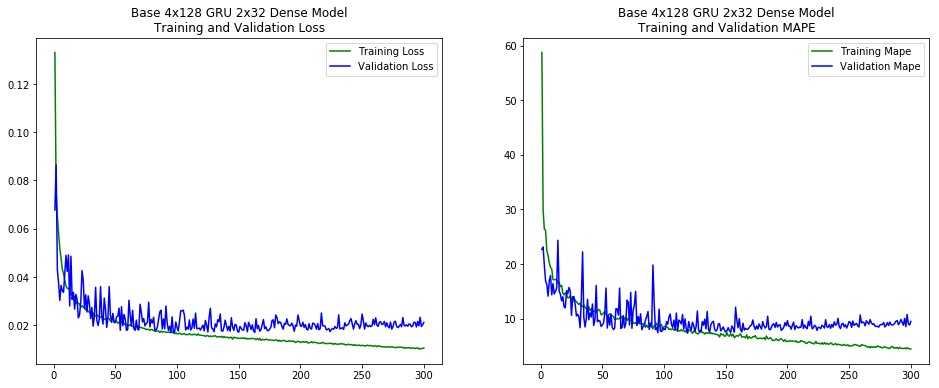

In [36]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mape_skip_zeros']:
        train_mape.append(a_mape)
    for a_mape in h['val_mape_skip_zeros']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 4x128 GRU 2x32 Dense Model\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('Base 4x128 GRU 2x32 Dense Model\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [37]:
print('min validation loss = {}\nepoch = {}'.format(min(val_loss), val_loss.index(min(val_loss))))

min validation loss = 0.01688502531981298
epoch = 94


In [38]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()))))

Train MAE = 1.380735
Validation MAE = 2.300585


In [40]:
# Load best model
best_model = load_model(os.path.join('models', 'base3mrb-4x128gru-2x32dense.best-epch176.h5'),
                       custom_objects={'mape_skip_zeros': mape_skip_zeros})
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [41]:
gen_pred = mu.DataGenerator(mrb_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                            batch_size=batch_size, step=step)
mrb_train_preds = best_model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
mrb_train_preds.shape

(18326, 1)

In [42]:
mrb_train_preds1 = np.concatenate([mrb_train_preds, np.zeros((mrb_train_preds.shape[0], 1))], axis=1)
mrb_train_preds1.shape

(18326, 2)

In [43]:
mrb_train_preds1 = my_pipeline.inverse_transform(mrb_train_preds1)
mrb_train_preds1

array([[ 93.13243686,   0.        ],
       [110.65523061,   0.        ],
       [114.5007738 ,   0.        ],
       ...,
       [ 56.27549769,   0.        ],
       [ 44.41468569,   0.        ],
       [ 43.70350692,   0.        ]])

In [44]:
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_train_data)):
    if (mrb_train_data[i, 0] > mu.MASK_VALUE) and (np.any(mrb_train_data[i - lookback:i, 0] > mu.MASK_VALUE)):
        mrb_train_preds_withnan[i] = mrb_train_preds1[j, 0]
        j += 1
mrb_train_preds_withnan.shape

(20000, 1)

In [45]:
mrb_train_data.shape

(20000, 2)

In [46]:
gen_val_pred = mu.DataGenerator(mrb_val_data,
                                lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                                batch_size=batch_size, step=step)
mrb_val_preds = best_model.predict_generator(gen_val_pred, workers=3, use_multiprocessing=False)
mrb_val_preds.shape

(11061, 1)

In [47]:
mrb_val_preds1 = np.concatenate([mrb_val_preds, np.zeros((mrb_val_preds.shape[0], 1))], axis=1)
mrb_val_preds1 = my_pipeline.inverse_transform(mrb_val_preds1)
mrb_val_preds_withnan = np.full((mrb_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_val_data)):
    if (mrb_val_data[i, 0] > mu.MASK_VALUE) and (np.any(mrb_val_data[i - lookback:i, 0] > mu.MASK_VALUE)):
        mrb_val_preds_withnan[i] = mrb_val_preds1[j, 0]
        j += 1
mrb_val_preds_withnan.shape

(11617, 1)

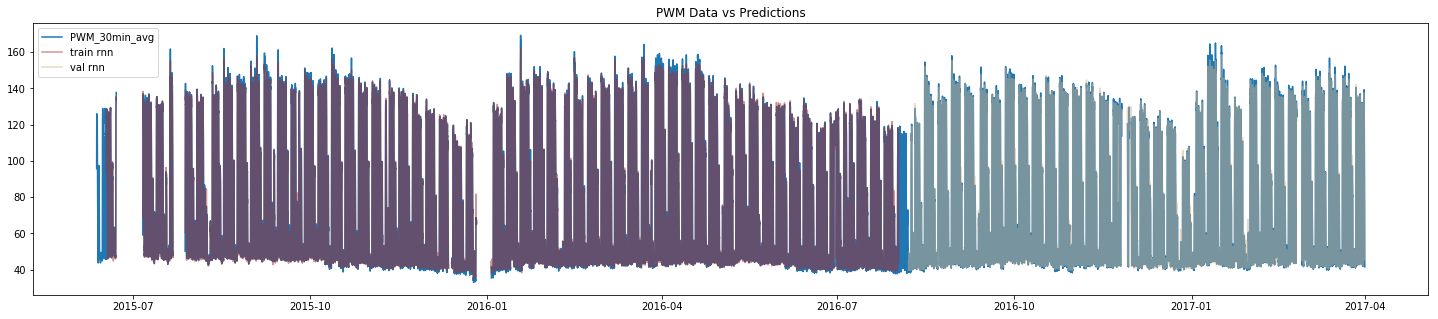

In [48]:
plt.figure(figsize=(25, 5))
plt.plot(mrb_train_df['PWM_30min_avg'])
plt.plot(mrb_train_df.index[:20000], mrb_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.plot(mrb_train_df.index[20000:], mrb_val_preds_withnan.flatten(), color='tan', alpha=.5, label='val rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

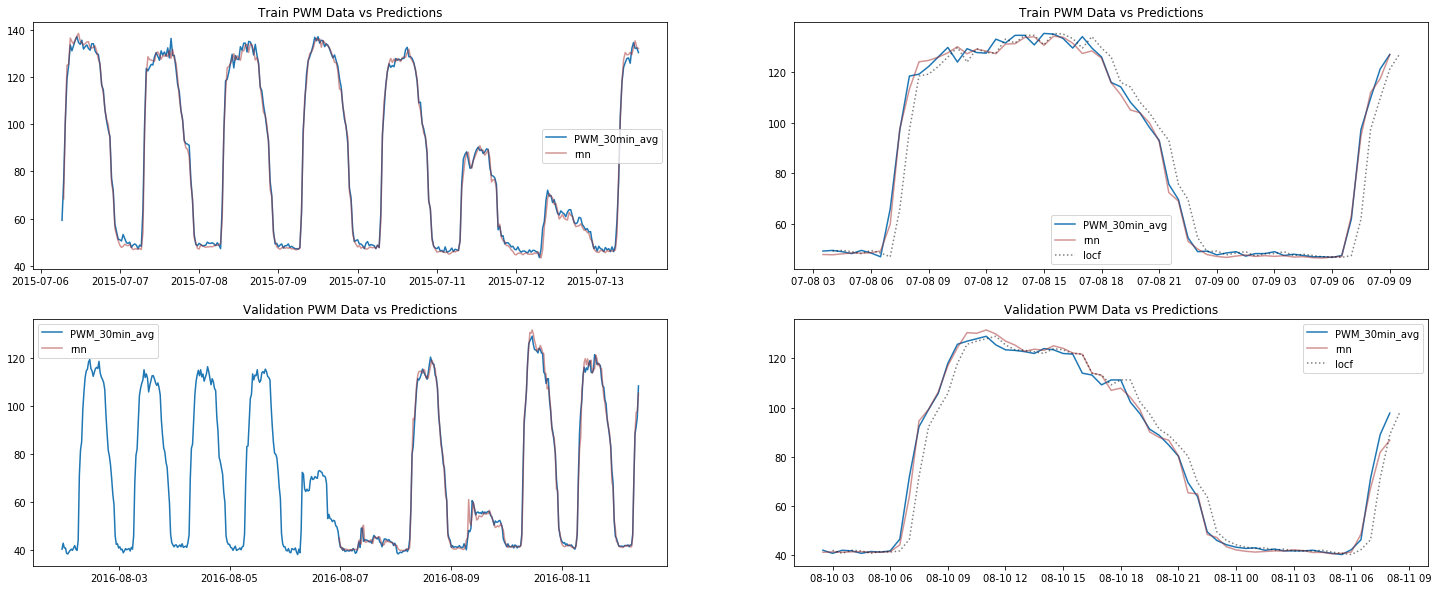

In [49]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(mrb_train_df.iloc[1000:1500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1000:1500], mrb_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1240:1300], mrb_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(mrb_train_df.index[1241:1301], mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(mrb_train_df.iloc[20000:20500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20000:20500], mrb_val_preds_withnan[:500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds_withnan[390:450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(mrb_train_df.index[20391:20451], mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1
plt.title('Validation PWM Data vs Predictions')
plt.legend()

## 4x128 GRU, 2x32 Dense Model with Dropout (0.2) and Recurrent Dropout (0.2)

In [21]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [57]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True, input_shape=(None, mrb_train_data.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, reset_after=True))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=[mape_skip_zeros])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
__________

In [22]:
gen_train = mu.DataGenerator(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(mrb_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 87


In [23]:
histories = []

In [24]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base3mrb-4x128gru-2x32dense-dropout020202-histories-epch150.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base3mrb-4x128gru-2x32dense-dropout020202-epch150.h5'),
                  custom_objects={'mape_skip_zeros': mape_skip_zeros})
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
__________

In [25]:
callbacks_list = [
    ModelCheckpoint(
        filepath='base3mrb-4x128gru-2x32dense-dropout020202.best-epchxxx.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [26]:
train_to_epoch = 300
start_epoch = 150
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=train_to_epoch,
                              callbacks=callbacks_list,
                              initial_epoch = start_epoch,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-06 23:49:55.807805

Training Duration = 3:51:35.274996


In [27]:
model.save('base3mrb-4x128gru-2x32dense-dropout020202-epch' + str(train_to_epoch) + '.h5')

In [28]:
with open('base3mrb-4x128gru-2x32dense-dropout020202-histories-epch' + str(train_to_epoch) + '.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

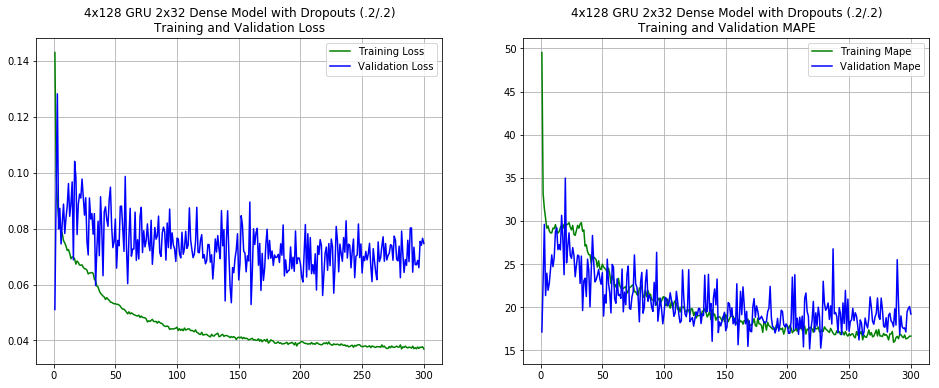

In [29]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mape_skip_zeros']:
        train_mape.append(a_mape)
    for a_mape in h['val_mape_skip_zeros']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts (.2/.2)\nTraining and Validation Loss')
plt.grid(True)
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts (.2/.2)\nTraining and Validation MAPE')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.036967
Validation min loss = 0.051060
Validation min epoch = 0


In [31]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()))))

Train MAE = 5.036769
Validation MAE = 6.956981


In [31]:
# Load best model
best_model = load_model(os.path.join('models', 'base1mrb-4x128gru-2x32dense-dropout0202.best-epch009.h5'))
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [32]:
gen_pred = mu.DataGenerator(mrb_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                            batch_size=batch_size, step=step)
mrb_train_preds = best_model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
mrb_train_preds.shape

(18329, 1)

In [33]:
mrb_train_preds1 = np.concatenate([mrb_train_preds, np.zeros((mrb_train_preds.shape[0], 1))], axis=1)
mrb_train_preds1.shape

(18329, 2)

In [34]:
mrb_train_preds1 = my_pipeline.inverse_transform(mrb_train_preds1)
mrb_train_preds1

array([[ 74.74044639,   0.        ],
       [110.93739937,   0.        ],
       [110.80068822,   0.        ],
       ...,
       [ 55.91540463,   0.        ],
       [ 50.85583938,   0.        ],
       [ 45.81737892,   0.        ]])

In [35]:
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_train_data)):
    if mrb_train_data[i, 0] > -1:
        mrb_train_preds_withnan[i] = mrb_train_preds1[j, 0]
        j += 1
mrb_train_preds_withnan.shape

(20000, 1)

In [36]:
gen_val_pred = mu.DataGenerator(mrb_val_data,
                                lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                                batch_size=batch_size, step=step)
mrb_val_preds = best_model.predict_generator(gen_val_pred, workers=3, use_multiprocessing=False)
mrb_val_preds.shape

(11061, 1)

In [37]:
mrb_val_preds1 = np.concatenate([mrb_val_preds, np.zeros((mrb_val_preds.shape[0], 1))], axis=1)
mrb_val_preds1 = my_pipeline.inverse_transform(mrb_val_preds1)
mrb_val_preds_withnan = np.full((mrb_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_val_data)):
    if mrb_val_data[i, 0] > -1:
        mrb_val_preds_withnan[i] = mrb_val_preds1[j, 0]
        j += 1
mrb_val_preds_withnan.shape

(11617, 1)

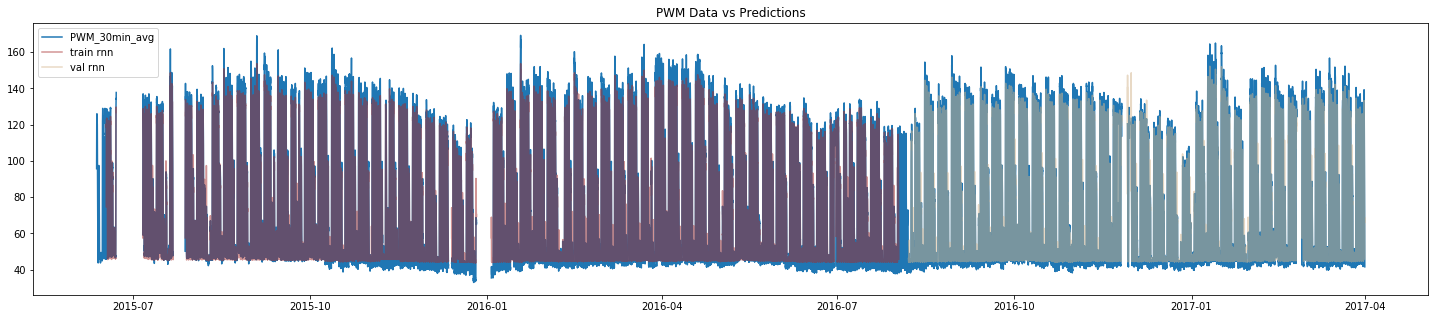

In [38]:
plt.figure(figsize=(25, 5))
plt.plot(mrb_train_df['PWM_30min_avg'])
plt.plot(mrb_train_df.index[:20000], mrb_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.plot(mrb_train_df.index[20000:], mrb_val_preds_withnan.flatten(), color='tan', alpha=.5, label='val rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

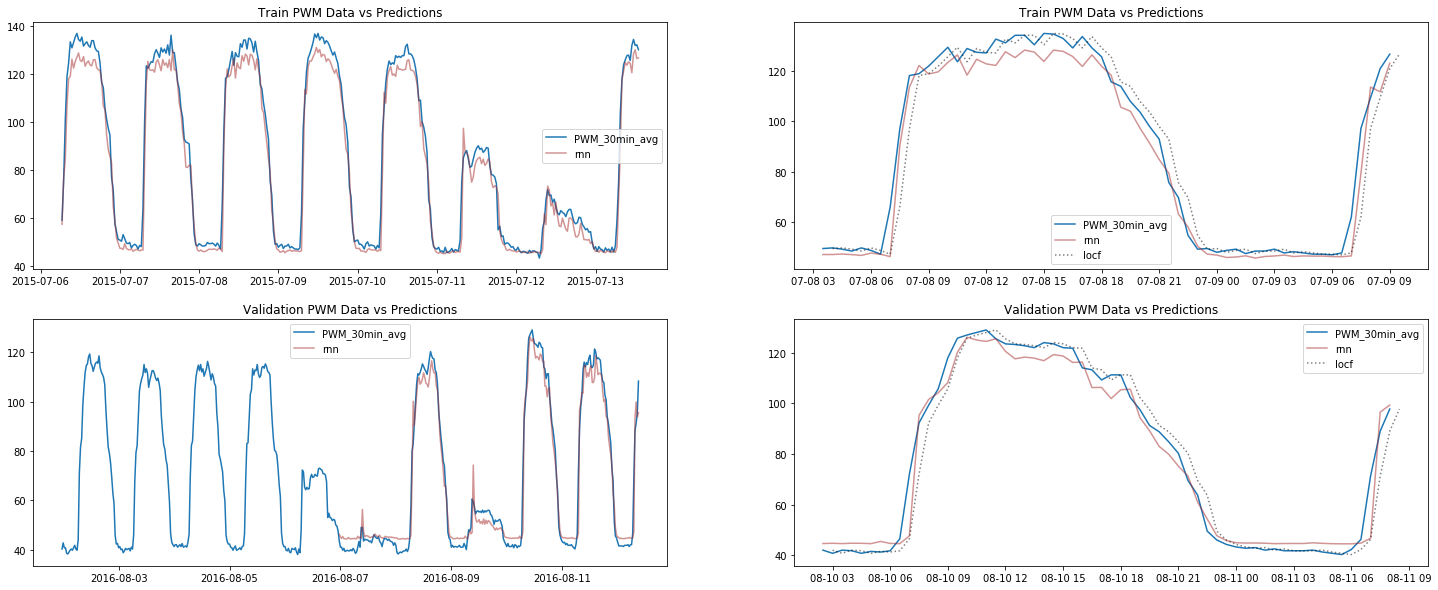

In [39]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(mrb_train_df.iloc[1000:1500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1000:1500], mrb_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1240:1300], mrb_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(mrb_train_df.index[1241:1301], mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(mrb_train_df.iloc[20000:20500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20000:20500], mrb_val_preds_withnan[:500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds_withnan[390:450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(mrb_train_df.index[20391:20451], mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1
plt.title('Validation PWM Data vs Predictions')
plt.legend()

# =========== ALL BELOW TO BE EDITED =================

## Base 4x128 GRU, 2x32 Dense Model with Shuffling of Samples within Mini-batch

In [20]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [21]:
model = Sequential()
model.add(layers.CuDNNGRU(128, return_sequences=True, input_shape=(None, mrb_train_data.shape[-1])))
model.add(layers.CuDNNGRU(128, return_sequences=True))
model.add(layers.CuDNNGRU(128, return_sequences=True))
model.add(layers.CuDNNGRU(128))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [22]:
# Shuffle = True
gen_train = mu.DataGenerator(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(mrb_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 87


In [23]:
callbacks_list = [
    ModelCheckpoint(
        filepath='base3mrb-4x128gru-2x32dense.best.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [24]:
histories = []

In [25]:
# # Temporary - to remove after training is completed
# # Load previous history
# with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout0200-histories.pkl'), 'rb') as infile:
#     histories = pickle.load(infile)
# # Load previous model
# from keras.models import load_model
# model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout0200.h5'))
# model.summary()

In [26]:
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=300,
                              callbacks=callbacks_list,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-02-28 09:40:27.851375

Training Duration = 1:00:22.237350


In [27]:
model.save('base3mrb-4x128gru-2x32dense.h5')

In [28]:
histories.append(history.history)

In [29]:
with open('base3mrb-4x128gru-2x32dense-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

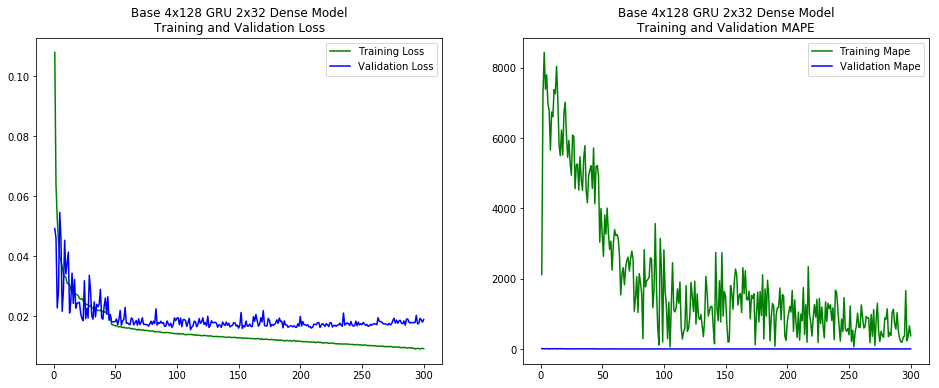

In [30]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 4x128 GRU 2x32 Dense Model\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('Base 4x128 GRU 2x32 Dense Model\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [48]:
print('min validation loss = {}\nepoch = {}'.format(min(val_loss), val_loss.index(min(val_loss))))

min validation loss = 0.015437334381200858
epoch = 110


In [49]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()))))

Train MAE = 1.224173
Validation MAE = 2.103337


In [50]:
# Load best model
best_model = load_model(os.path.join('models', 'base3mrb-4x128gru-2x32dense.best-epch110.h5'))
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [51]:
gen_pred = mu.DataGenerator(mrb_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                            batch_size=batch_size, step=step)
mrb_train_preds = best_model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
mrb_train_preds.shape

(18326, 1)

In [52]:
mrb_train_preds1 = np.concatenate([mrb_train_preds, np.zeros((mrb_train_preds.shape[0], 1))], axis=1)
mrb_train_preds1.shape

(18326, 2)

In [53]:
mrb_train_preds1 = my_pipeline.inverse_transform(mrb_train_preds1)
mrb_train_preds1

array([[ 95.3824292 ,   0.        ],
       [109.15126178,   0.        ],
       [116.39155219,   0.        ],
       ...,
       [ 56.55176441,   0.        ],
       [ 44.40556058,   0.        ],
       [ 42.09183866,   0.        ]])

In [54]:
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_train_data)):
    if (mrb_train_data[i, 0] > mu.MASK_VALUE) and (np.any(mrb_train_data[i - lookback:i, 0] > mu.MASK_VALUE)):
        mrb_train_preds_withnan[i] = mrb_train_preds1[j, 0]
        j += 1
mrb_train_preds_withnan.shape

(20000, 1)

In [55]:
gen_val_pred = mu.DataGenerator(mrb_val_data,
                                lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                                batch_size=batch_size, step=step)
mrb_val_preds = best_model.predict_generator(gen_val_pred, workers=3, use_multiprocessing=False)
mrb_val_preds.shape

(11061, 1)

In [56]:
mrb_val_preds1 = np.concatenate([mrb_val_preds, np.zeros((mrb_val_preds.shape[0], 1))], axis=1)
mrb_val_preds1 = my_pipeline.inverse_transform(mrb_val_preds1)
mrb_val_preds_withnan = np.full((mrb_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_val_data)):
    if (mrb_val_data[i, 0] > mu.MASK_VALUE) and (np.any(mrb_val_data[i - lookback:i, 0] > mu.MASK_VALUE)):
        mrb_val_preds_withnan[i] = mrb_val_preds1[j, 0]
        j += 1
mrb_val_preds_withnan.shape

(11617, 1)

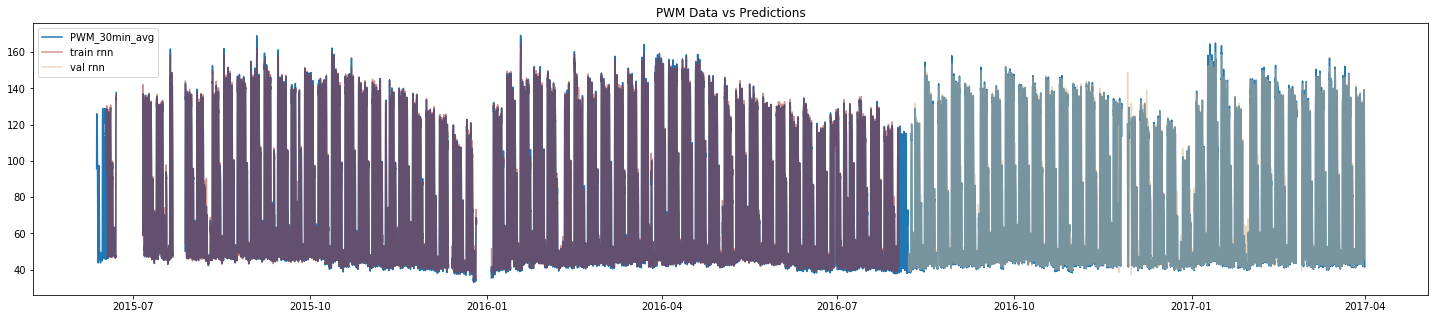

In [57]:
plt.figure(figsize=(25, 5))
plt.plot(mrb_train_df['PWM_30min_avg'])
plt.plot(mrb_train_df.index[:20000], mrb_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.plot(mrb_train_df.index[20000:], mrb_val_preds_withnan.flatten(), color='tan', alpha=.5, label='val rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

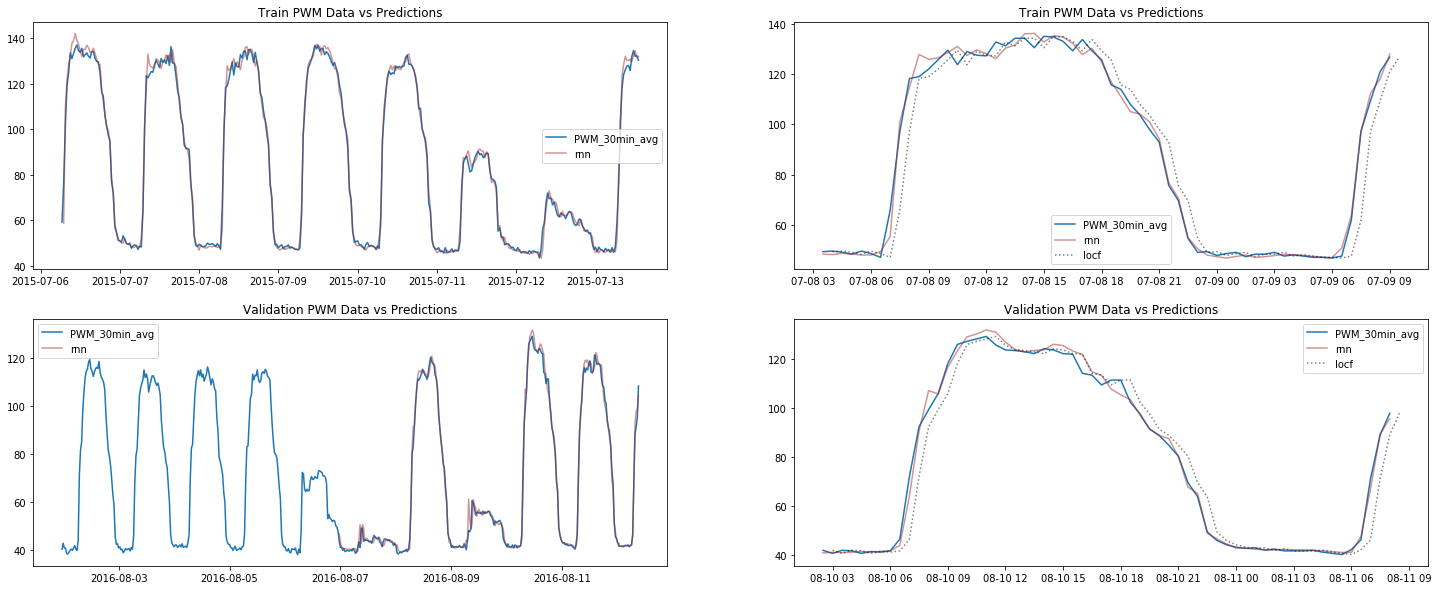

In [58]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(mrb_train_df.iloc[1000:1500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1000:1500], mrb_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1240:1300], mrb_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(mrb_train_df.index[1241:1301], mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(mrb_train_df.iloc[20000:20500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20000:20500], mrb_val_preds_withnan[:500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds_withnan[390:450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(mrb_train_df.index[20391:20451], mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1
plt.title('Validation PWM Data vs Predictions')
plt.legend()

## 4x128 GRU, 2x32 Dense Model with Dropout and Recurrent Dropout (0.2/0.2), shuffled data

In [20]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [21]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True, input_shape=(None, mrb_train_data.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, reset_after=True))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [22]:
gen_train = mu.DataGenerator(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(mrb_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 87


In [23]:
callbacks_list = [
    ModelCheckpoint(
        filepath='base3mrb-4x128gru-2x32dense-dropout0202.best.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [24]:
histories = []

In [ ]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base3mrb-4x128gru-2x32dense-dropout0202-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base3mrb-4x128gru-2x32dense-dropout0202.h5'))
model.summary()

In [25]:
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=150,
                              callbacks=callbacks_list,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-02-28 13:26:57.631557

Training Duration = 3:51:47.737562


In [26]:
model.save('base3mrb-4x128gru-2x32dense-drop0202.h5')

In [27]:
histories.append(history.history)

In [28]:
with open('base3mrb-4x128gru-2x32dense-dropout0202-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

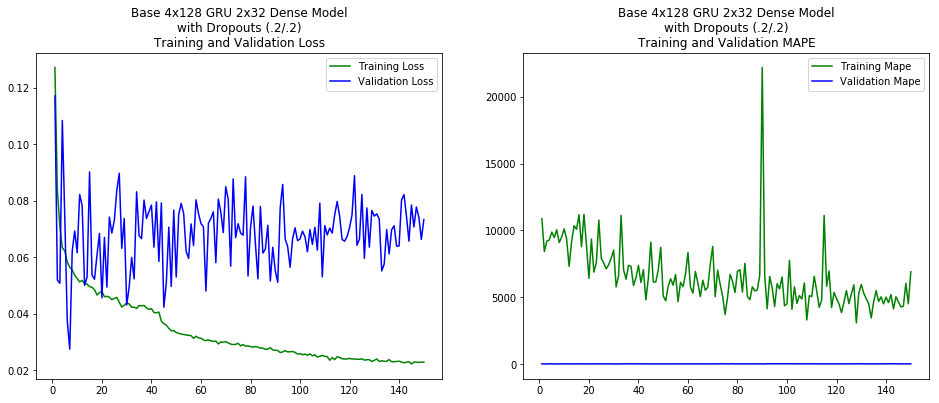

In [29]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 4x128 GRU 2x32 Dense Model\nwith Dropouts (.2/.2)\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('Base 4x128 GRU 2x32 Dense Model\nwith Dropouts (.2/.2)\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [30]:
print('min validation loss = {}\nepoch = {}'.format(min(val_loss), val_loss.index(min(val_loss))))

min validation loss = 0.02746134789066298
epoch = 6


In [31]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()))))

Train MAE = 3.025788
Validation MAE = 3.741609


In [33]:
# Load best model
best_model = load_model(os.path.join('models', 'base3mrb-4x128gru-2x32dense-dropout0202.best-epch006.h5'))
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [34]:
gen_pred = mu.DataGenerator(mrb_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                            batch_size=batch_size, step=step)
mrb_train_preds = best_model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
mrb_train_preds.shape

(18326, 1)

In [35]:
mrb_train_preds1 = np.concatenate([mrb_train_preds, np.zeros((mrb_train_preds.shape[0], 1))], axis=1)
mrb_train_preds1.shape

(18326, 2)

In [36]:
mrb_train_preds1 = my_pipeline.inverse_transform(mrb_train_preds1)
mrb_train_preds1

array([[ 73.24565443,   0.        ],
       [107.87856656,   0.        ],
       [111.7664371 ,   0.        ],
       ...,
       [ 54.14777306,   0.        ],
       [ 48.18874971,   0.        ],
       [ 44.49704616,   0.        ]])

In [37]:
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_train_data)):
    if (mrb_train_data[i, 0] > mu.MASK_VALUE) and (np.any(mrb_train_data[i - lookback:i, 0] > mu.MASK_VALUE)):
        mrb_train_preds_withnan[i] = mrb_train_preds1[j, 0]
        j += 1
mrb_train_preds_withnan.shape

(20000, 1)

In [38]:
gen_val_pred = mu.DataGenerator(mrb_val_data,
                                lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                                batch_size=batch_size, step=step)
mrb_val_preds = best_model.predict_generator(gen_val_pred, workers=3, use_multiprocessing=False)
mrb_val_preds.shape

(11061, 1)

In [39]:
mrb_val_preds1 = np.concatenate([mrb_val_preds, np.zeros((mrb_val_preds.shape[0], 1))], axis=1)
mrb_val_preds1 = my_pipeline.inverse_transform(mrb_val_preds1)
mrb_val_preds_withnan = np.full((mrb_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_val_data)):
    if (mrb_val_data[i, 0] > mu.MASK_VALUE) and (np.any(mrb_val_data[i - lookback:i, 0] > mu.MASK_VALUE)):
        mrb_val_preds_withnan[i] = mrb_val_preds1[j, 0]
        j += 1
mrb_val_preds_withnan.shape

(11617, 1)

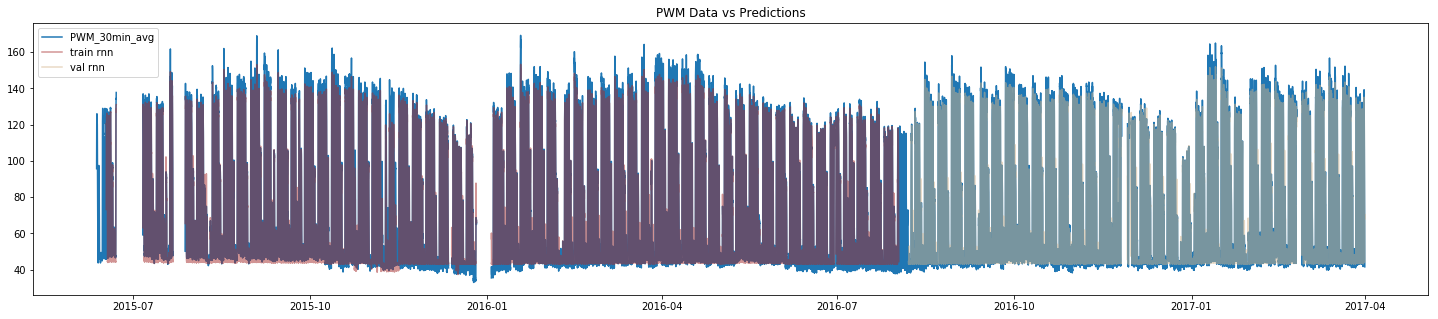

In [40]:
plt.figure(figsize=(25, 5))
plt.plot(mrb_train_df['PWM_30min_avg'])
plt.plot(mrb_train_df.index[:20000], mrb_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.plot(mrb_train_df.index[20000:], mrb_val_preds_withnan.flatten(), color='tan', alpha=.5, label='val rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

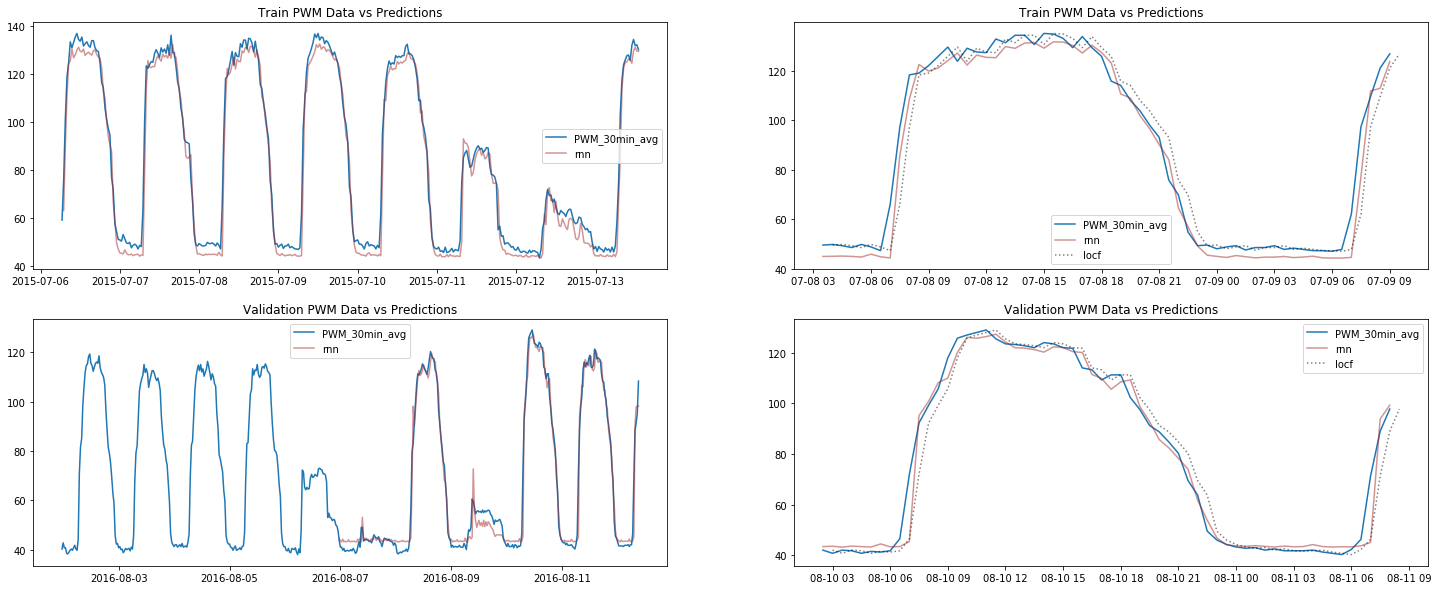

In [41]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(mrb_train_df.iloc[1000:1500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1000:1500], mrb_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1240:1300], mrb_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(mrb_train_df.index[1241:1301], mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(mrb_train_df.iloc[20000:20500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20000:20500], mrb_val_preds_withnan[:500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds_withnan[390:450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(mrb_train_df.index[20391:20451], mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1
plt.title('Validation PWM Data vs Predictions')
plt.legend()